In [1]:
%load_ext autoreload
%autoreload 2

import os
import time

import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

sys.path.append('/oasis/projects/nsf/csd181/yuncong/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage.filters.rank import entropy
from skimage.morphology import remove_small_objects, disk
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage import img_as_float

from sklearn import mixture

In [ ]:
# section_ind = 66
# dm = DataManager(stack='MD589', section=section_ind, segm_params_id='tSLIC200', load_mask=True)
# # dm.mask = rescale(dm.thumbmail_mask.astype(np.bool), 32).astype(np.bool)
# # display(dm.mask)

In [284]:
def generate_mask(img):

    h, w = img.shape
    
    e = entropy(img, disk(5))
    
    clf = mixture.GMM(n_components=2, covariance_type='full')
    clf.fit(np.atleast_2d(e[e > 0.1]).T)

    means = np.squeeze(clf.means_)

    order = np.argsort(means)
    means = means[order]

    covars =np.squeeze(clf.covars_)
    covars = covars[order]

    weights = clf.weights_
    weights = weights[order]

    counts, bins = np.histogram(e.flat, bins=100, density=True);

    gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

    thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]

    v = e > thresh

    l = label(v, background=0)
    mask = l == np.argmax([p.area for p in regionprops(l+1)])
    
    mask = ~remove_small_objects(~mask, min_size=10000, connectivity=8)
    
    l = label(v)
    l[v > 0] = -1
    props = regionprops(l)
    
    border_holes = np.where([np.any(p.coords[:,0] == 0) or np.any(p.coords[:,1] == 0) \
                             or np.any(p.coords[:,0] == h-1) or np.any(p.coords[:,1] == w-1) 
                             for p in props])[0]

    for i in border_holes:
        c = props[i].coords
        mask[c[:,0], c[:,1]] = 0
    
    return ~mask

In [4]:
# def f(stack, sec):
#     img = rgb2gray(imread('/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped/'+stack+'_%04d_thumbnail_aligned_cropped.tif'%sec))
    
#     try:
#         mask = generate_mask(img)
#     except:
#         raise Exception('%d'%sec)
    
#     img2 = img.copy()
#     img2[~mask] = 0

#     imsave('/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_mask/'+stack+'_%04d_thumbnail_aligned_cropped_mask.png'%sec, img_as_float(mask))
#     imsave('/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_masked/'+stack+'_%04d_thumbnail_aligned_cropped_masked.png'%sec, img2)

In [ ]:
# stack ='MD592'

# mask_dir = '/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_mask/'
# masked_tb_dir = '/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_masked/'

# if not os.path.exists(mask_dir):
#     os.makedirs(mask_dir)
# if not os.path.exists(masked_tb_dir):
#     os.makedirs(masked_tb_dir)

# first, last = section_range_lookup[stack]
    
# _ = Parallel(n_jobs=16)(delayed(f)(stack, sec) for sec in range(first, last+1))

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [7]:
img = rgb2gray(imread('/home/yuncong/CSHL_data_processed/MD603/MD603_thumbnail_sorted_aligned/MD603_0110_thumbnail_aligned.tif'))

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


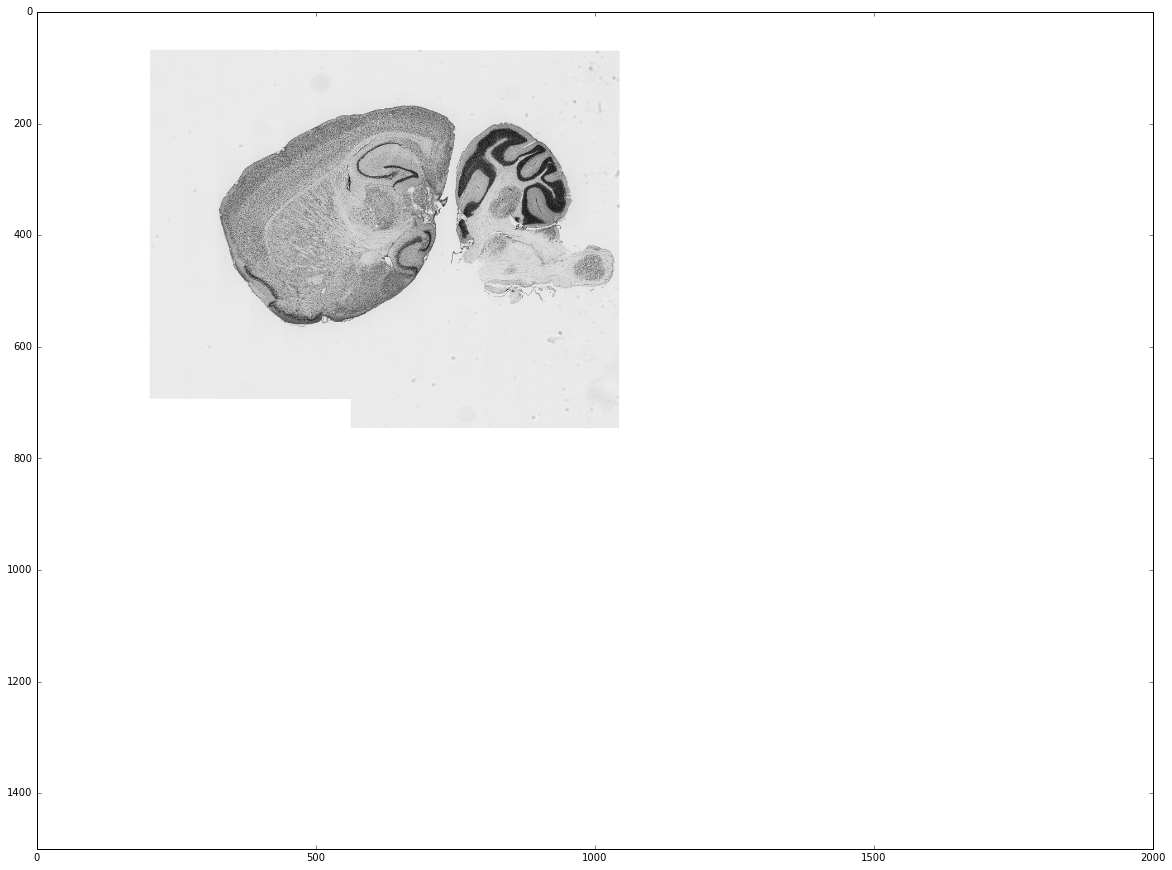

In [8]:
plt.figure(figsize=(20,20));
plt.imshow(img, cmap=plt.cm.gray);

num. components 3
3.33018566822


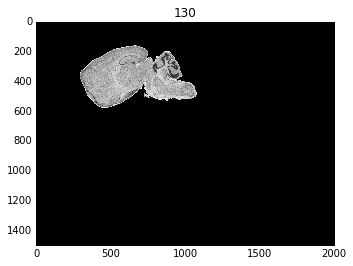

num. components 3
3.31685233489


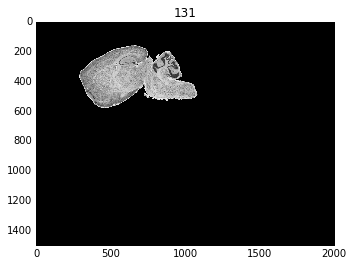

num. components 3
3.19400595212


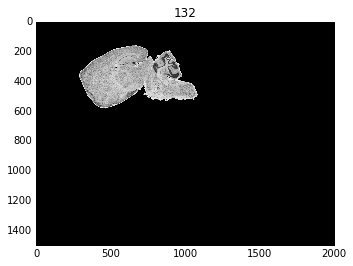

num. components 3
3.5292700572


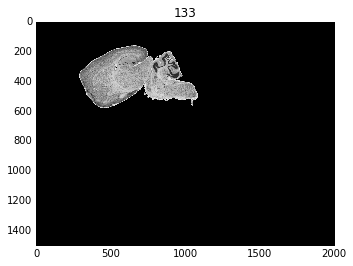

num. components 3
3.48118019915


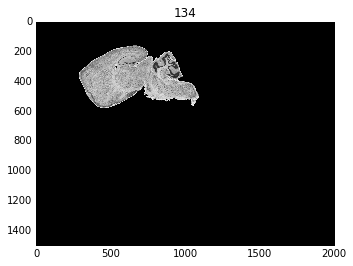

num. components 3
2.90828422359


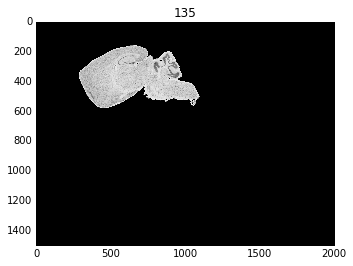

num. components 3
3.2635761759


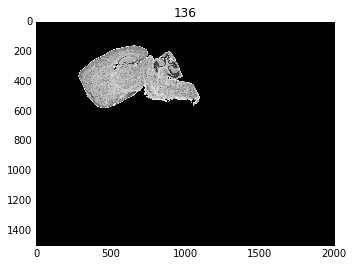

num. components 3
3.37827552628


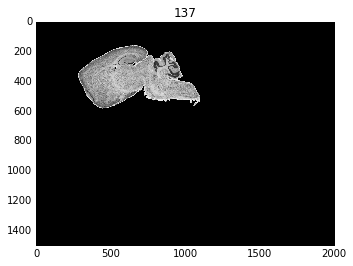

num. components 3
3.21968496446


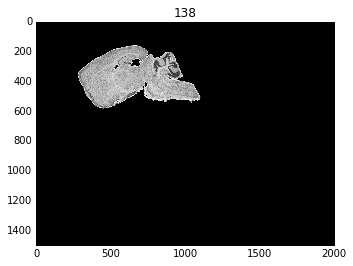

num. components 3
3.43447974234


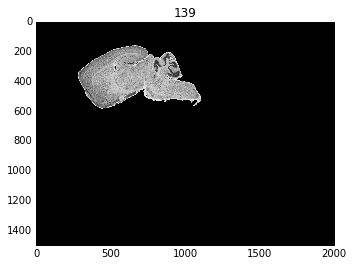

num. components 3
3.20199926692


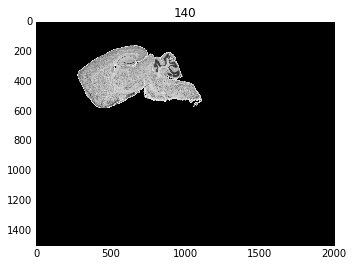

num. components 3
3.39185577319


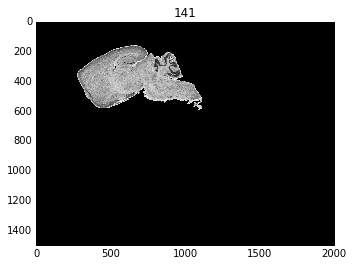

num. components 3
3.2635761759


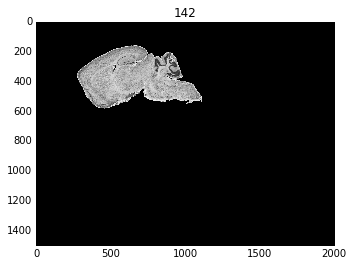

num. components 3
3.33018566822


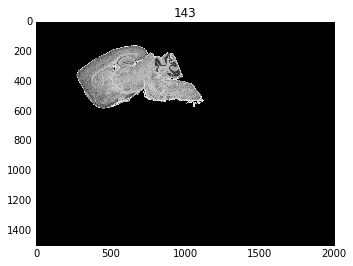

num. components 3
3.31685233489


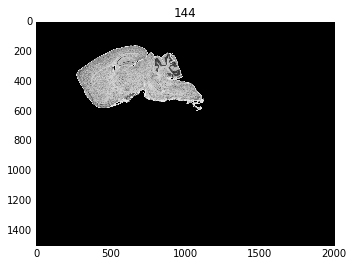

num. components 3
3.43969871766


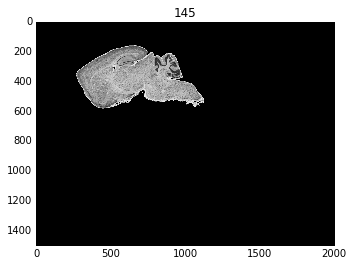

num. components 3
3.38160421452


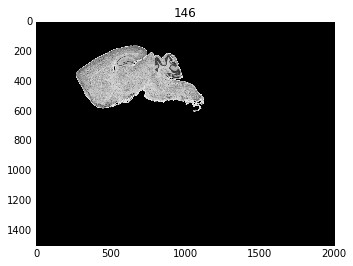

num. components 3
3.51519598313


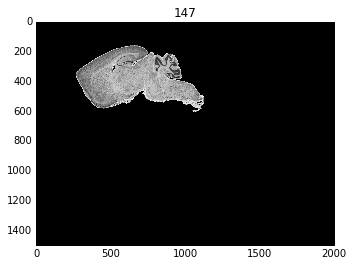

num. components 3
3.54822411278


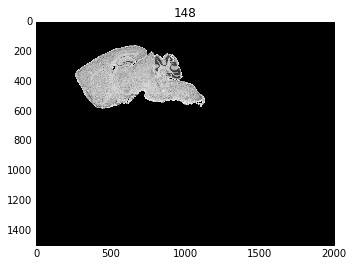

num. components 3
3.56254510044


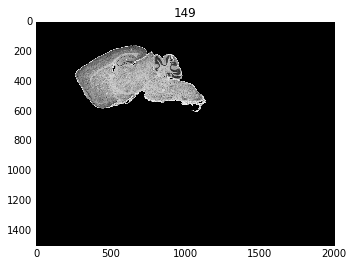

num. components 3
3.77693813139


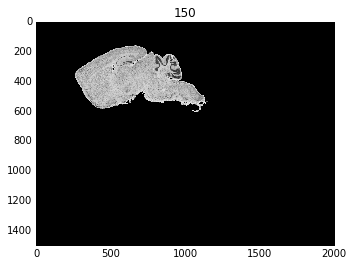

num. components 3
3.7468146746


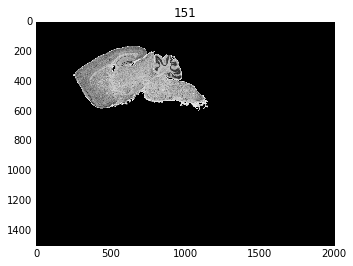

num. components 3
3.19400595212


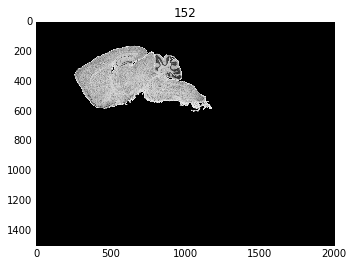

KeyboardInterrupt: 

In [182]:
for s in range(130, 291):

    img = rgb2gray(imread('/home/yuncong/CSHL_data_processed/MD603_thumbnail_aligned/MD603_%04d_thumbnail_aligned.tif' % s))

    h, w = img.shape
    e = entropy(img, disk(5))

#     plt.figure();
#     plt.title('distribution');
#     plt.hist(e.flatten(), bins=100);

    x = np.atleast_2d(e[e > .1]).T

    bics = []
    clfs = []
    # for nc in [2]:
    for nc in [2,3]:
        clf = mixture.GMM(n_components=nc, covariance_type='full')
        clf.fit(x)
        bic = clf.bic(x)
        bics.append(bic)
        clfs.append(clf)

    print 'num. components', np.argsort(bics)[0] + 2

    clf = clfs[np.argsort(bics)[0]]

    means = np.squeeze(clf.means_)

    order = np.argsort(means)
    means = means[order]

    covars = np.squeeze(clf.covars_)
    covars = covars[order]

    weights = clf.weights_
    weights = weights[order]

    # consider only the largest two components
    if nc > 2:
        order = sorted(np.argsort(weights)[-2:])
        weights = weights[order]
        covars = covars[order]
        means = means[order]

    counts, bins = np.histogram(e.flat, bins=100, density=True);

    # ignore small components
    gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

#     plt.figure();
#     plt.title('fitted guassians');
#     plt.plot(bins, gs.T);

    thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]
    # thresh = 4
    print thresh

    mask = e > thresh

    mask = remove_small_objects(mask, min_size=10000, connectivity=8)

    img2 = img.copy()
    img2[~mask] = 0

    plt.figure();
    plt.imshow(img2, cmap=plt.cm.gray);
    plt.title('%d' % s);
    plt.show();

In [11]:
from skimage.morphology import remove_small_holes

num. components 2
3.42587155717


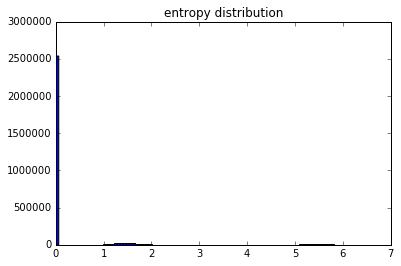

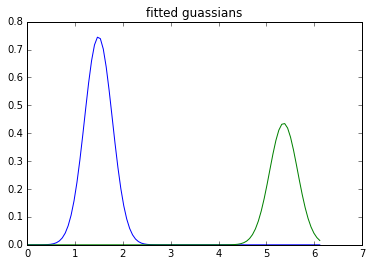

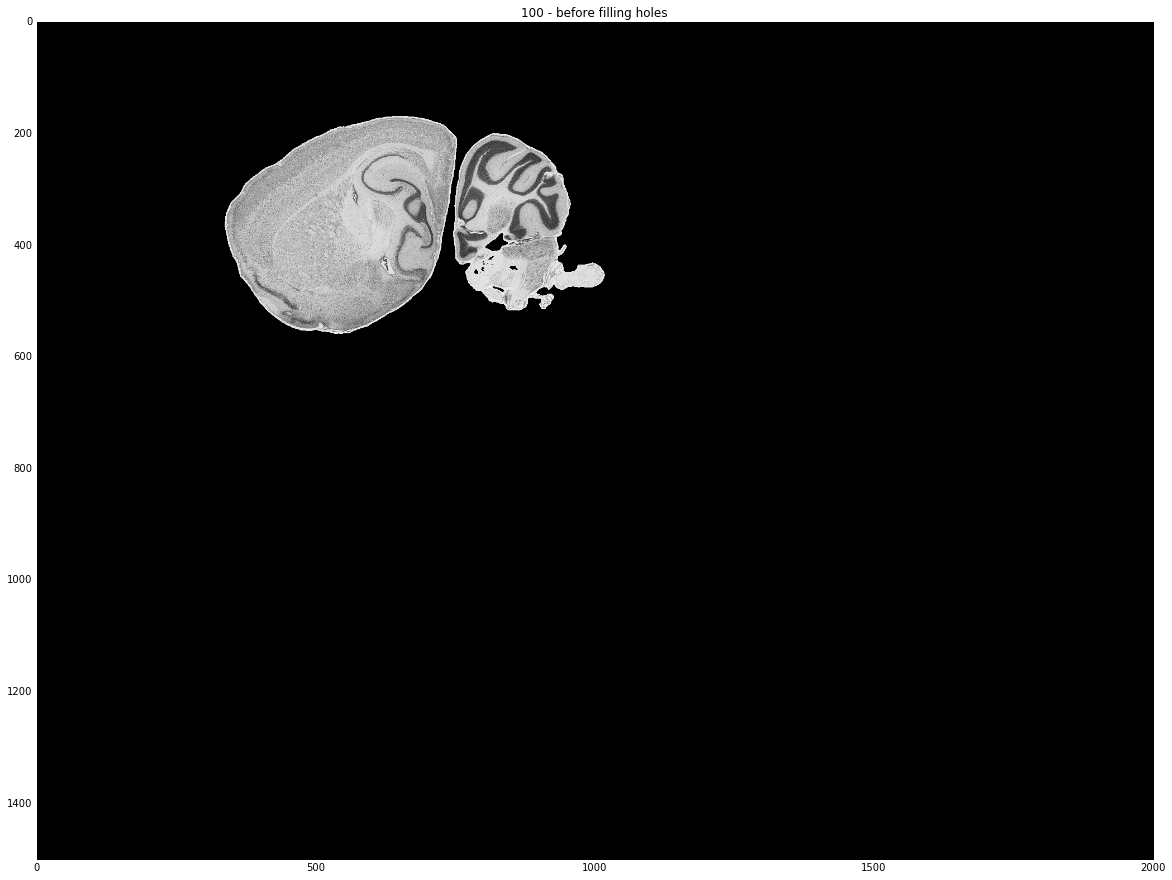

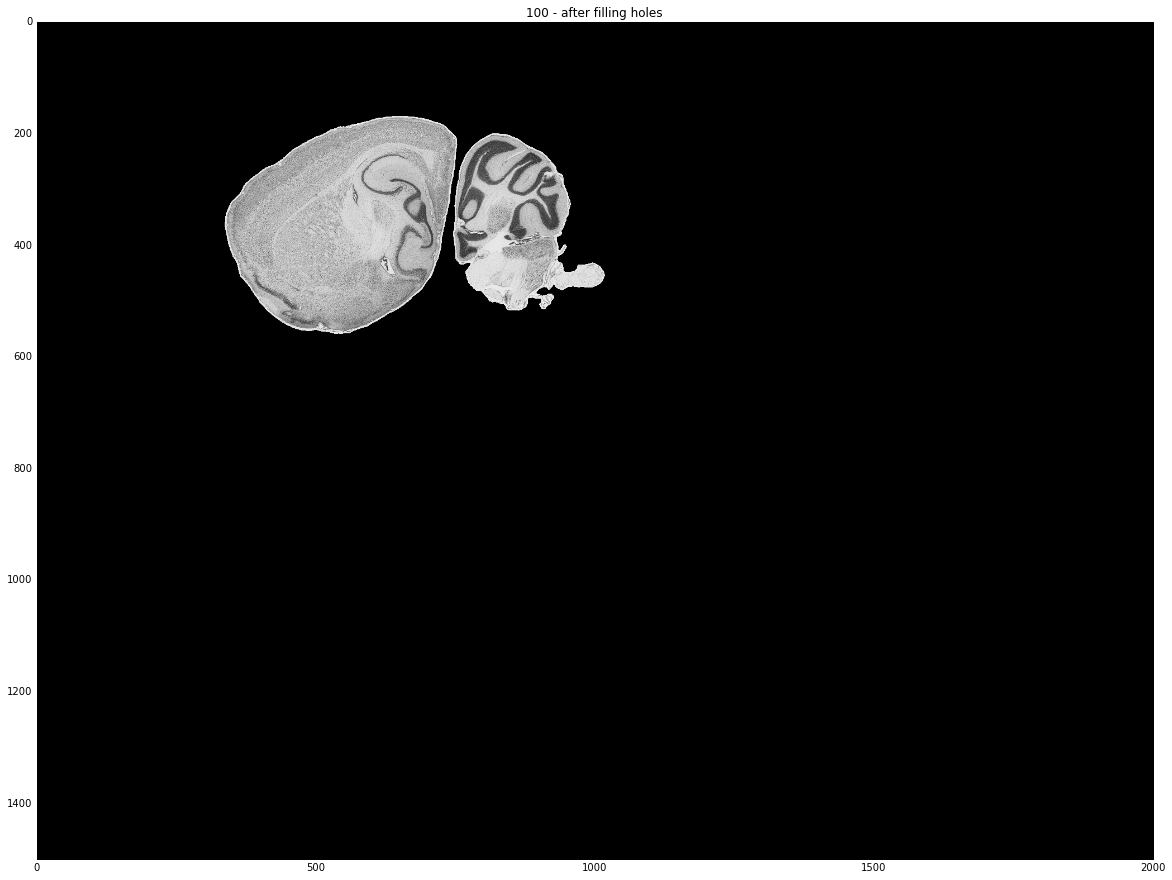

In [268]:
# WARNING!!! This is problematic when the entropy distribution is not gaussian, but skewed 
# This article about peak finding might help

s = 100

img_rgb = imread('/home/yuncong/CSHL_data_processed/MD603/MD603_thumbnail_sorted_aligned/MD603_%04d_thumbnail_aligned.tif' % s)

img = rgb2gray(img_rgb)

h, w = img.shape
e = entropy(img, disk(5))

plt.figure();
plt.title('entropy distribution');
plt.hist(e.flatten(), bins=100);

x = np.atleast_2d(e[e > .1]).T

bics = []
clfs = []
# for nc in [3]:
for nc in [2,3]:
    clf = mixture.GMM(n_components=nc, covariance_type='full')
    clf.fit(x)
    bic = clf.bic(x)
    bics.append(bic)
    clfs.append(clf)
    
print 'num. components', np.argsort(bics)[0] + 1

clf = clfs[np.argsort(bics)[0]]

means = np.atleast_1d(np.squeeze(clf.means_))

order = np.argsort(means)
means = means[order]

# covars = np.squeeze(clf.covars_)
covars = np.atleast_1d(np.squeeze(clf.covars_))
covars = covars[order]

weights = clf.weights_
weights = weights[order]

# consider only the largest two components

if nc > 2:
    order = sorted(np.argsort(weights)[-2:])
    weights = weights[order]
    covars = covars[order]
    means = means[order]
    
counts, bins = np.histogram(e.flat, bins=100, density=True);

# ignore small components
gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

plt.figure();
plt.title('fitted guassians');
plt.plot(bins, gs.T);

thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]
# thresh = 4
print thresh

mask = e > thresh

mask = remove_small_objects(mask, min_size=10000, connectivity=8)

img2 = img.copy()
img2[~mask] = 0

plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - before filling holes' % s);
plt.show();

mask = remove_small_holes(mask, min_size=10000, connectivity=8)

img2 = img.copy()
img2[~mask] = 0

plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - after filling holes' % s);
plt.show();

In [176]:
from skimage.measure import find_contours

30.9702281952


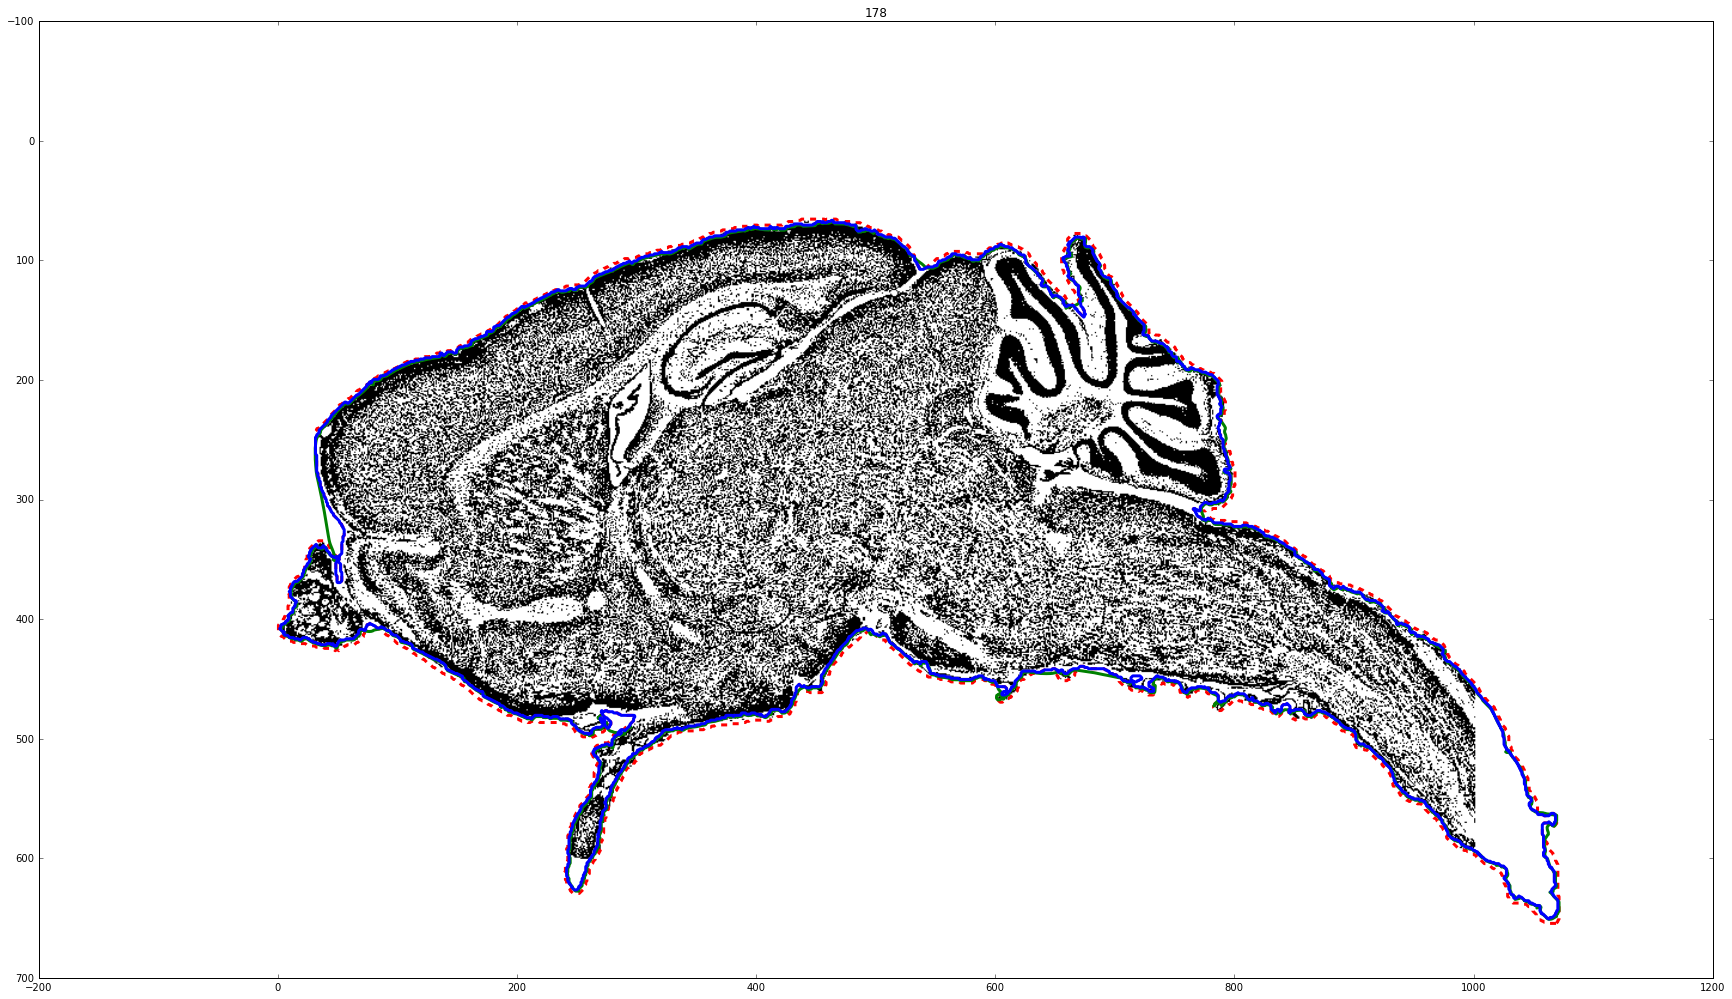

In [303]:
for s in range(178,179):
    
    img_rgb = imread('/home/yuncong/CSHL_data_processed/MD603/MD603_thumbnail_sorted_aligned/MD603_%04d_thumbnail_aligned.tif' % s)
    img = rgb2gray(img_rgb )
    
    entropy_mask = generate_mask(img)
    
    init_contours = [yxs[:,::-1] for yxs in find_contours(entropy_mask, .5)]
    
    img_adap = threshold_adaptive(img, 51)
    img_adap[~entropy_mask] = 1
    
    init_cnt = init_contours[0]

    t = time.time()

    # alpha: length
    # beta: second order

    snake = active_contour(img_adap, init_cnt, 
                           alpha=1., beta=10., gamma=0.01, 
                           w_line=0., w_edge=1., 
                           max_iterations=100)
    #                        convergence=.01)

    print time.time() - t
    
    bg = np.zeros(img.shape[:2], bool)
    xys = points_inside_contour(snake.astype(np.int))
    bg[xys[:,1], xys[:,0]] = 1
    
    final_cnt = find_contours(bg & entropy_mask, .5)[0]
    
    fig = plt.figure(figsize=(30, 30));

    plt.imshow(img_adap[ymin:ymax+1, xmin:xmax+1])
    plt.plot(init_cnt[:, 0]-xmin, init_cnt[:, 1]-ymin, '--r', lw=3)
    plt.plot(snake[:, 0]-xmin, snake[:, 1]-ymin, '-g', lw=3)
    plt.plot(final_cnt[:, 1]-xmin, final_cnt[:, 0]-ymin, '-b', lw=3)
    plt.title(s)

    plt.show()

In [ ]:
final_cnt*32

In [ ]:
img_rgb = imread('/home/yuncong/CSHL_data_processed/MD603/MD603_thumbnail_sorted_aligned/MD603_%04d_thumbnail_aligned.tif' % s)


In [ ]:
ymin = 100
ymax = 700
xmin = 200
xmax = 1200

In [178]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian

In [71]:
display_image(img)

/home/yuncong/Brain/preprocess/tmp.jpg

In [99]:
from skimage.filter import threshold_adaptive, canny

In [257]:
from annotation_utilities import *

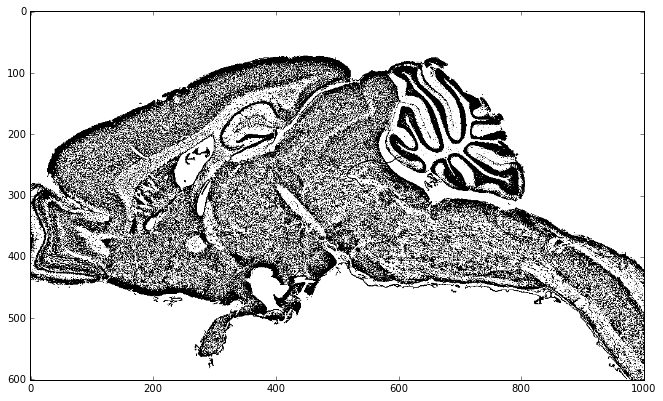

In [188]:
# plt.figure(figsize=(11,11))
# plt.imshow(img_adap[ymin:ymax+1, xmin:xmax+1])

In [256]:
# for init_cnt in init_contours[1:]:

init_cnt = init_contours[0]

t = time.time()

# alpha: length
# beta: second order

snake = active_contour(img_adap, init_cnt, 
                       alpha=1., beta=10., gamma=0.01, 
                       w_line=0., w_edge=1., 
                       max_iterations=1000)
#                        convergence=.01)

print time.time() - t

115.252163172


In [258]:
bg = np.zeros(img.shape[:2], bool)
xys = points_inside_contour(snake.astype(np.int))
bg[xys[:,1], xys[:,0]] = 1

In [260]:
final_cnt = find_contours(bg & mask, .5)[0]

In [261]:
fig = plt.figure(figsize=(30, 30));

plt.imshow(img_adap[ymin:ymax+1, xmin:xmax+1])
plt.plot(init_cnt[:, 0]-xmin, init_cnt[:, 1]-ymin, '--r', lw=3)
plt.plot(snake[:, 0]-xmin, snake[:, 1]-ymin, '-g', lw=3)
plt.plot(final_cnt[:, 1]-xmin, final_cnt[:, 0]-ymin, '-b', lw=3)

plt.show()

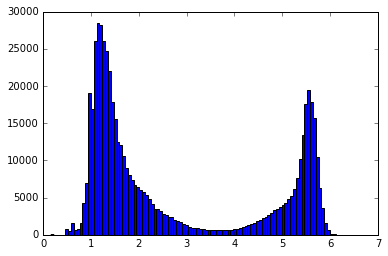

In [13]:
plt.hist(e[e>.1], bins=100);

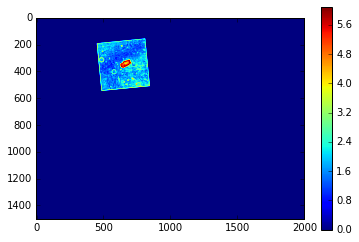

In [200]:
plt.imshow(e);
plt.colorbar();

In [122]:
xmin, xmax, ymin, ymax = bbox_2d(img2)

img3 = img2[ymin-10:ymax+10, xmin-10:xmax+10].copy()

h, w = img3.shape[:2]
init = np.r_[np.c_[np.arange(w), np.zeros((w,))], 
             np.c_[w*np.ones((h,)), np.arange(h)], 
             np.c_[np.arange(w, 0, -1), h*np.ones((w,))], 
             np.c_[np.zeros((h,)), np.arange(h, 0, -1)]]

In [160]:
sys.path.append('/home/yuncong/Brain/preprocess/morphsnakes')
import morphsnakes
from collections import deque
from registration_utilities import *

scoremap_viz = img_as_ubyte(img3.copy())

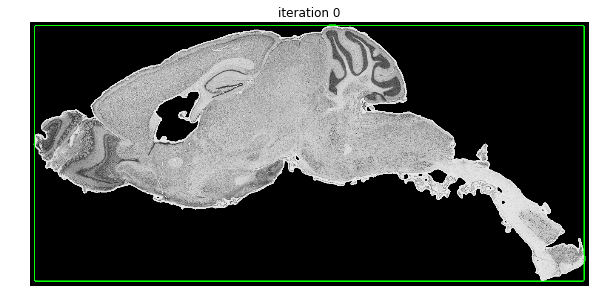

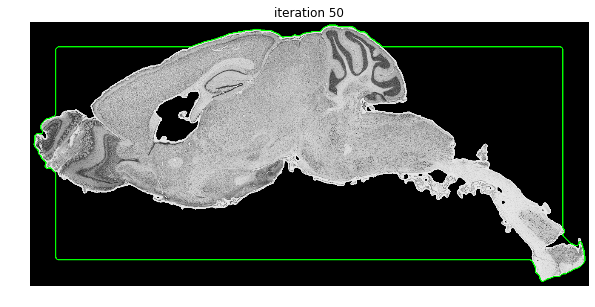

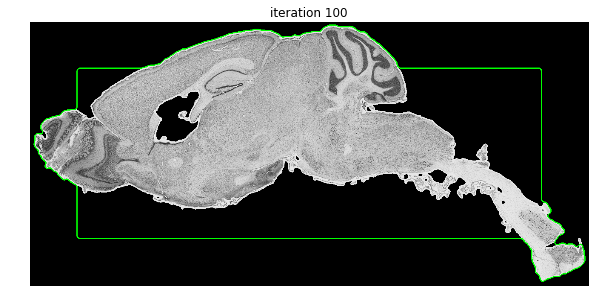

KeyboardInterrupt: 

In [178]:
init_levelset = np.zeros((h, w))
init_levelset[10:-10, 10:-10] = 1.
# init_levelset[inside_points_inroi[:,1], inside_points_inroi[:,0]] = 1.

t = time.time()

msnake = morphsnakes.MorphACWE(img3.astype(np.float), smoothing=3, lambda1=1., lambda2=1.)

msnake.levelset = init_levelset.copy()

dq = deque([None, None])
for i in range(1000): 

    # at stable stage, the levelset (thus contour) will oscilate, 
    # so instead of comparing to previous levelset, must compare to the one before the previous
    oneBefore_levelset = dq.popleft()

    if i > 10:
#                 print np.count_nonzero(msnake.levelset - oneBefore_levelset)
        if np.count_nonzero(msnake.levelset - oneBefore_levelset) < 3:
            break

    dq.append(msnake.levelset)

    msnake.step()

    if i % 50 == 0:
        show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

# # in the final levelset, inside could be 0. or 1., hard to say        
# edge_arr = np.r_[msnake.levelset[:,0], msnake.levelset[:,-1], msnake.levelset[0], msnake.levelset[-1]]        
# pos_edge_num = np.count_nonzero(edge_arr)
# bool_arr = msnake.levelset.astype(np.bool)

# if pos_edge_num < len(edge_arr) - pos_edge_num:
#     # inside is 1.
#     mean_inside_score = scoremap_roi[bool_arr].mean()
# else:
#     # inside is 0.
#     mean_inside_score = scoremap_roi[~bool_arr].mean()
#     msnake.levelset = 1. - msnake.levelset

# # after this, all inside pixels have value 1.

# print 'mean inside score:', mean_inside_score
# print 'area:', np.count_nonzero(bool_arr)
# print 'snake iteration:', i

# if mean_inside_score < .3:
#     continue

# sys.stderr.write('snake completes %f s\n' % (time.time() - t))

# #         m = binary_closing(msnake.levelset, disk(20))
# #         plt.figure(figsize=(10,10));
# #         plt.imshow(m);
# #         plt.show();

# t = time.time()

# new_cnts = find_contours(msnake.levelset, 0.5)
# new_cnts = [c[:, ::-1] for c in new_cnts]

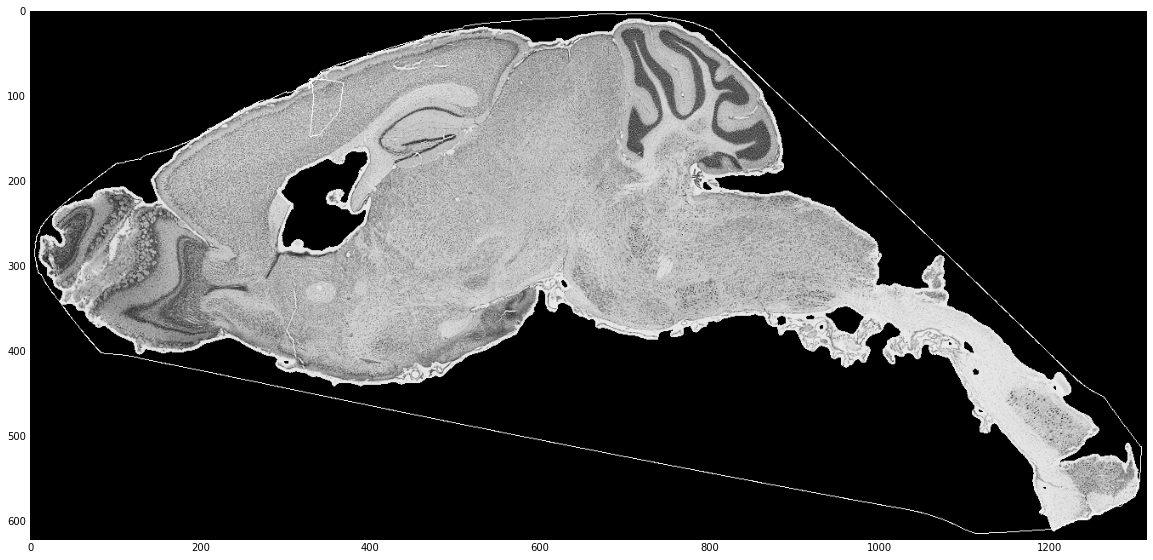

In [145]:
from skimage.segmentation import active_contour
cnt = active_contour(img3, init.astype(np.float), alpha=.1, beta=.001, gamma=0.001, w_edge=10.)

img4 = img3.copy()
# img4[cnt[:,1].astype(np.int), cnt[:,0].astype(np.int)] = 1.
cv2.polylines(img4, [cnt.astype(np.int)], True, (1.,1.,1.))
plt.figure(figsize=(20,20));
plt.imshow(img4, cmap=plt.cm.gray);

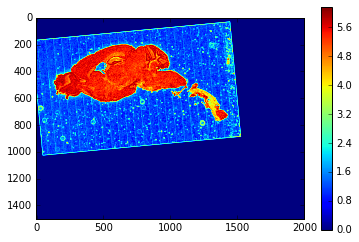

In [36]:
plt.imshow(e);
plt.colorbar();